In [27]:
!pip install catboost

# Meteorological Data Classification with JAX/Flax

## 1. Imports and Configuration

This section loads the necessary libraries for data processing, traditional machine learning, and the JAX/Flax framework. A global random seed is set to ensure reproducibility of the data split and model initialization.

In [28]:
import xml.etree.ElementTree as ET
from pathlib import Path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# JAX/Flax Libraries for the core NN implementation
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from flax.training import train_state
import optax

# Scikit-learn Utilities for data handling and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, brier_score_loss
)

# Benchmark Classifier Imports (Will be used in Section 3.2)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

# Set global random seed
seed = 42
np.random.seed(seed)
key = random.PRNGKey(seed)

## 2. Data Acquisition and Transformation

The raw grid data from `O-A0038-003.xml` is parsed, and the coordinates are generated. This section focuses on creating the **Classification Dataset** `(Longitude, Latitude, label)` by identifying valid (`label=1`) versus invalid (`label=0`) temperature readings.

### XML Parsing and Grid Creation

In [18]:
# --- Data Characteristics ---
from google.colab import drive
drive.mount('/content/drive')
xml_file = '/content/drive/MyDrive/Meteorological Data/O-A0038-003.xml'
lat_points = 120
lon_points = 67
start_lon = 120.00
start_lat = 21.88
resolution = 0.03
INVALID_VALUE = -999.0

# Read and parse the XML data
tree = ET.parse(xml_file)
root = tree.getroot()
namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
content_str = root.find('.//cwa:Content', namespace).text

# Parse the temperature grid into a NumPy array (120 rows x 67 columns)
lines = content_str.strip().split('\n')
all_floats = []
for line in lines:
    if not line.strip():
        continue
    floats_in_line = [float(val) for val in line.split(',') if val.strip()]
    all_floats.extend(floats_in_line)

temp_grid = np.array(all_floats).reshape(lat_points, lon_points)

print(f"Temperature grid shape: {temp_grid.shape}")
valid_temps = temp_grid[temp_grid != INVALID_VALUE]
print(f"Valid temperature range: {valid_temps.min():.2f}°C to {valid_temps.max():.2f}°C")

Mounted at /content/drive
Temperature grid shape: (120, 67)
Valid temperature range: 4.30°C to 35.80°C


### Classification Dataset Creation

The core classification task is to predict data validity. The dataset is structured as: `(Longitude,Latitude,label)`, where `label=0` for `Value=−999.0` and `label=1` otherwise.

In [19]:
# Generate coordinates
longitudes = start_lon + np.arange(lon_points) * resolution
latitudes = start_lat + np.arange(lat_points) * resolution

classification_data = []

for i in range(lat_points):
    for j in range(lon_points):
        lon = longitudes[j]
        lat = latitudes[i]
        temp_value = temp_grid[i, j]

        # Classification Dataset Rule: label=0 if invalid, label=1 if valid
        label = 1 if temp_value != INVALID_VALUE else 0
        classification_data.append({'longitude': lon, 'latitude': lat, 'label': label})

data_cls = pd.DataFrame(classification_data)

print("\n--- Classification Data Summary ---")
print(f"Total entries: {len(data_cls)}")
print(f"Valid data points (label=1): {(data_cls['label'] == 1).sum()}")
print(f"Invalid data points (label=0): {(data_cls['label'] == 0).sum()}")
print(data_cls.head())


--- Classification Data Summary ---
Total entries: 8040
Valid data points (label=1): 3495
Invalid data points (label=0): 4545
   longitude  latitude  label
0     120.00     21.88      0
1     120.03     21.88      0
2     120.06     21.88      0
3     120.09     21.88      0
4     120.12     21.88      0


### Data Splitting and Scaling

The data is split into Train (70%), Validation (20%), and Test (10%) sets with **stratified sampling** to maintain the balance of valid/invalid data points across the sets. Features (Longitude, Latitude) are then standardized for optimal model performance.

In [20]:
# Extract features (X) and labels (y)
X_cls = data_cls[['longitude', 'latitude']].values
y_cls = data_cls['label'].values

# Split data: 70% train, 20% validation, 10% test (stratified)
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=seed, stratify=y_cls
)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(
    X_temp_cls, y_temp_cls, test_size=(1/3), random_state=seed, stratify=y_temp_cls
)

print(f"\nTraining set size: {len(X_train_cls)}")
print(f"Validation set size: {len(X_val_cls)}")
print(f"Test set size: {len(X_test_cls)}")

# Standardize features (fit only on training data)
scaler_cls = StandardScaler()
X_train_scaled_cls = scaler_cls.fit_transform(X_train_cls)
X_val_scaled_cls = scaler_cls.transform(X_val_cls)
X_test_scaled_cls = scaler_cls.transform(X_test_cls)

# Convert to JAX arrays for neural network training
X_train_jax = jnp.array(X_train_scaled_cls)
y_train_jax = jnp.array(y_train_cls)
X_val_jax = jnp.array(X_val_scaled_cls)
y_val_jax = jnp.array(y_val_cls)
X_test_jax = jnp.array(X_test_scaled_cls)
y_test_jax = jnp.array(y_test_cls)


Training set size: 5628
Validation set size: 1608
Test set size: 804


## 3. Classification Model Training


### Benchmark Model Training

Before implementing the JAX Neural Network, a variety of traditional and ensemble classifiers are trained to establish a performance benchmark.

In [21]:
# Utility function for training and evaluation
all_results_cls = {}
def fit_qda(X_train, y_train):
    X_train, y_train = jnp.array(X_train), jnp.array(y_train)
    classes = np.unique(np.array(y_train))
    priors, means, covariances = {}, {}, {}
    for k in classes:
        X_k = X_train[y_train == k]
        priors[k] = X_k.shape[0] / X_train.shape[0]
        means[k] = jnp.mean(X_k, axis=0)
        covariances[k] = jnp.cov(X_k, rowvar=False, bias=True)
    return priors, means, covariances

@jax.jit
def predict_qda(params, X):
    priors, means, covariances = params
    scores = []
    for k in sorted(priors.keys()):
        mu_k, cov_k = means[k], covariances[k]
        inv_cov_k = jnp.linalg.inv(cov_k)
        log_det_cov_k = jnp.log(jnp.linalg.det(cov_k))
        diff = jax.vmap(lambda x: x - mu_k)(X)
        quadratic_term = jnp.sum((diff @ inv_cov_k) * diff, axis=1)
        score_k = -0.5 * quadratic_term - 0.5 * log_det_cov_k + jnp.log(priors[k])
        scores.append(score_k)
    scores_stacked = jnp.stack(scores, axis=0)
    predictions = jnp.argmax(scores_stacked, axis=0)
    probabilities = jax.nn.softmax(scores_stacked, axis=0)
    return predictions, probabilities

# 2. Wrapping QDA as Scikit-learn

class JAX_QDA_Wrapper:
    def __init__(self):
        self.params_ = None

    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values
        self.params_ = fit_qda(X, y)
        return self

    def predict(self, X):
        if hasattr(X, 'values'):
            X = X.values
        predictions, _ = predict_qda(self.params_, jnp.array(X))
        return np.array(predictions)

    def predict_proba(self, X):
        if hasattr(X, 'values'):
            X = X.values
        # Transpose
        _, probabilities = predict_qda(self.params_, jnp.array(X))
        return np.array(probabilities).T

def evaluate_classifier(model, model_name, X_train, y_train, X_test, y_test, results_dict):
    """Trains and evaluates a classification model using scikit-learn metrics."""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_test_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        # Get probabilities for the positive class (class 1)
        y_test_prob = model.predict_proba(X_test)[:, 1]
        test_brier = brier_score_loss(y_test, y_test_prob)
    else:
        # If the model doesn't support probabilities, set Brier score to NaN
        test_brier = np.nan

    # Metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

    print(f"Training Time: {train_time:.4f}s")
    print(f"Test Metrics: Acc={test_acc:.4f}, Prec={test_prec:.4f}, Rec={test_rec:.4f}, F1={test_f1:.4f}, Brier={test_brier:.4f}")

    results_dict[model_name] = {
        'train_time': train_time,
        'test_acc': test_acc,
        'test_prec': test_prec,
        'test_rec': test_rec,
        'test_f1': test_f1,
        'test_brier': test_brier
    }
    return model

print("Starting Classification Benchmark Models Training...")
print("="*60)

# Define models
models = {
    "QDA (JAX)": JAX_QDA_Wrapper(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=seed, max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=10, n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(random_state=seed, probability=True),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=seed, verbose=False)
}

# Train and evaluate all benchmark models
for name, model in models.items():
    evaluate_classifier(
        model, name,
        X_train_scaled_cls, y_train_cls,
        X_test_scaled_cls, y_test_cls,
        all_results_cls
    )

print("\n" + "="*60)
print("Classification Benchmark Training Complete!")
print("="*60)

Starting Classification Benchmark Models Training...

Training QDA (JAX)
Training Time: 4.7211s
Test Metrics: Acc=0.8271, Prec=0.8207, Rec=0.7714, F1=0.7953, Brier=0.1301

Training K-Nearest Neighbors
Training Time: 0.0098s
Test Metrics: Acc=0.9776, Prec=0.9798, Rec=0.9686, F1=0.9741, Brier=0.0147

Training Decision Tree
Training Time: 0.0160s
Test Metrics: Acc=0.9614, Prec=0.9518, Rec=0.9600, F1=0.9559, Brier=0.0339

Training Random Forest
Training Time: 0.7999s
Test Metrics: Acc=0.9776, Prec=0.9770, Rec=0.9714, F1=0.9742, Brier=0.0195

Training Naive Bayes
Training Time: 0.0022s
Test Metrics: Acc=0.8072, Prec=0.8854, Rec=0.6400, F1=0.7430, Brier=0.1701

Training Support Vector Machine
Training Time: 2.4169s
Test Metrics: Acc=0.9577, Prec=0.9675, Rec=0.9343, F1=0.9506, Brier=0.0289

Training XGBoost
Training Time: 0.7522s
Test Metrics: Acc=0.9764, Prec=0.9825, Rec=0.9629, F1=0.9726, Brier=0.0180

Training LightGBM


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Time: 0.2194s
Test Metrics: Acc=0.9776, Prec=0.9826, Rec=0.9657, F1=0.9741, Brier=0.0177

Training CatBoost
Training Time: 0.4406s
Test Metrics: Acc=0.9677, Prec=0.9709, Rec=0.9543, F1=0.9625, Brier=0.0265

Classification Benchmark Training Complete!


### Neural Network (Flax/JAX) Training

The core neural network model uses the **JAX** framework for high-performance computing, with **Flax** providing a convenient API for defining the architecture and **Optax** for the optimization routine.

#### Model Architecture and Setup

In [22]:
# Define the simple Feedforward Neural Network (FNN)
class Classifier(nn.Module):
    """A simple feedforward neural network for classification."""
    hidden_dim: int = 32
    num_classes: int = 2

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_classes)(x)
        return x  # Returns logits

# Initialize the model and calculate parameters
model_cls = Classifier(hidden_dim=32, num_classes=2)
key, init_key = random.split(key)
params_cls = model_cls.init(init_key, jnp.ones((1, 2)))
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_cls))

print(f"Neural Network Architecture: Input(2) -> Dense({model_cls.hidden_dim}) -> ReLU -> Dense({model_cls.hidden_dim}) -> ReLU -> Dense({model_cls.num_classes})")
print(f"Total Parameters: {param_count}")

# Define the training state (parameters + optimizer)
learning_rate = 0.001
tx = optax.adam(learning_rate)
state_cls = train_state.TrainState.create(
    apply_fn=model_cls.apply,
    params=params_cls['params'],
    tx=tx
)

Neural Network Architecture: Input(2) -> Dense(32) -> ReLU -> Dense(32) -> ReLU -> Dense(2)
Total Parameters: 1218


#### JAX/Flax Core Functions

JAX's functional programming paradigm allows defining pure, *JIT-compiled functions* for the training and evaluation loops, drastically improving performance.

In [23]:
def cross_entropy_loss(logits, labels):
    """Compute categorical cross-entropy loss."""
    y_one_hot = jax.nn.one_hot(labels, num_classes=2)
    log_probs = jax.nn.log_softmax(logits)
    return -jnp.mean(jnp.sum(y_one_hot * log_probs, axis=-1))

def compute_metrics(logits, labels):
    """Compute loss and accuracy."""
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    return {'loss': loss, 'accuracy': accuracy}

@jax.jit
def train_step(state, batch_x, batch_y):
    """Single JAX training step, calculating gradients and updating state."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_x)
        return cross_entropy_loss(logits, batch_y)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step(params, batch_x, batch_y):
    """Single JAX evaluation step."""
    logits = model_cls.apply({'params': params}, batch_x)
    return compute_metrics(logits, batch_y)

@jax.jit
def predict_fn(params, X):
    """JAX prediction step (returns logits)."""
    return model_cls.apply({'params': params}, X)

#### Training Loop with Early Stopping

In [24]:
# Training parameters
num_epochs = 1000
batch_size = 32
patience = 10
patience_counter = 0
best_val_loss = float('inf')
best_params = state_cls.params

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting Neural Network Training...\n")
nn_start_time = time.time()

for epoch in range(num_epochs):
    # Shuffle and create mini-batches
    key, subkey = random.split(key)
    perm = random.permutation(subkey, len(X_train_jax))
    X_train_shuffled = X_train_jax[perm]
    y_train_shuffled = y_train_jax[perm]

    for i in range(0, len(X_train_jax), batch_size):
        x_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        state_cls, _ = train_step(state_cls, x_batch, y_batch)

    # Compute and store metrics
    train_metrics = eval_step(state_cls.params, X_train_jax, y_train_jax)
    val_metrics = eval_step(state_cls.params, X_val_jax, y_val_jax)

    train_loss = float(train_metrics['loss'])
    val_loss = float(val_metrics['loss'])

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(float(train_metrics['accuracy']))
    val_accs.append(float(val_metrics['accuracy']))

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = state_cls.params
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_accs[-1]:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accs[-1]:.4f}")

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

nn_train_time = time.time() - nn_start_time
params_nn_cls = best_params
print(f"\nNeural Network Training Complete! Time: {nn_train_time:.4f}s, Epochs: {len(train_losses)}")


Starting Neural Network Training...


Early stopping at epoch 40

Neural Network Training Complete! Time: 14.1897s, Epochs: 40


#### Neural Network Test Evaluation

The final, best-performing parameters are used to evaluate performance on the unseen test set, and results are added to the comparison dictionary.


NEURAL NETWORK DETAILED EVALUATION (Classification)

Confusion Matrix:
[[447   7]
 [ 11 339]]

Test Metrics:
  Accuracy:  0.9776
  Precision: 0.9798
  Recall:    0.9686
  F1 Score:  0.9741
  Brier Score: 0.0189


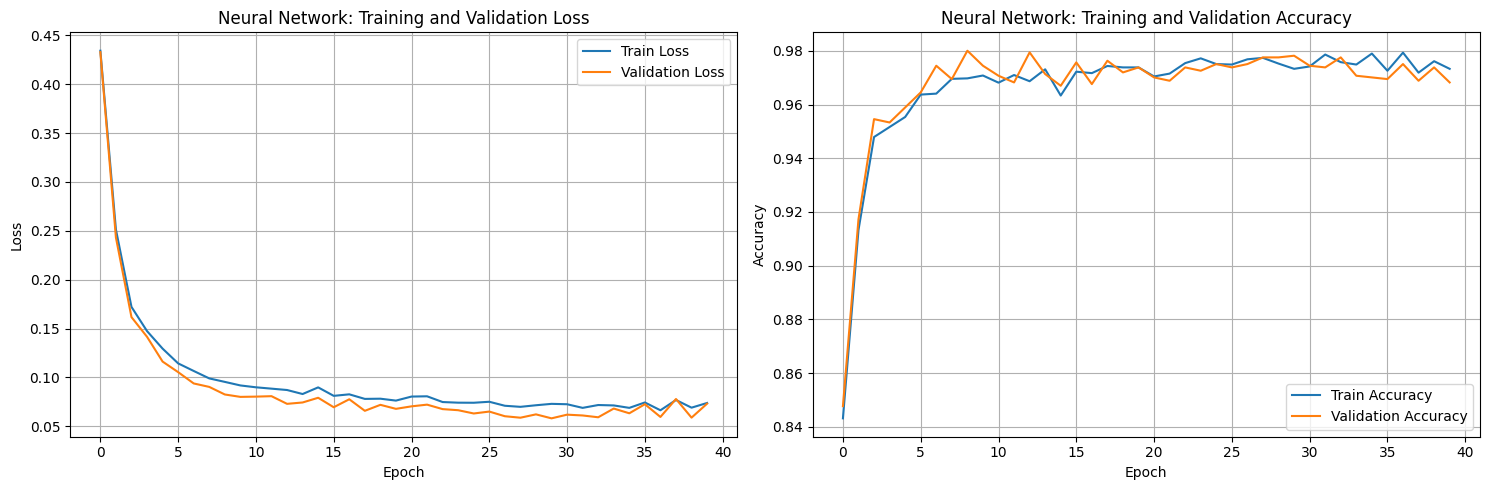


Training history saved to 'classification_nn_training_history.png'


In [25]:
# Evaluate the JAX/Flax classifier on the test set
logits_test = predict_fn(params_nn_cls, X_test_jax)
y_test_pred_nn = np.array(jnp.argmax(logits_test, axis=-1))
y_test_prob_nn = np.array(jax.nn.softmax(logits_test))

nn_test_acc = accuracy_score(y_test_cls, y_test_pred_nn)
nn_test_prec = precision_score(y_test_cls, y_test_pred_nn, zero_division=0)
nn_test_rec = recall_score(y_test_cls, y_test_pred_nn, zero_division=0)
nn_test_f1 = f1_score(y_test_cls, y_test_pred_nn, zero_division=0)
nn_test_brier = brier_score_loss(y_test_cls, y_test_prob_nn[:, 1])

# Add to results
all_results_cls['Neural Network (Flax)'] = {
    'train_time': nn_train_time,
    'test_acc': nn_test_acc,
    'test_prec': nn_test_prec,
    'test_rec': nn_test_rec,
    'test_f1': nn_test_f1,
    'test_brier': nn_test_brier
}

# Detailed output
cm = confusion_matrix(y_test_cls, y_test_pred_nn)

print(f"\n{'='*60}")
print("NEURAL NETWORK DETAILED EVALUATION (Classification)")
print(f"{'='*60}\n")
print(f"Confusion Matrix:\n{cm}\n")
print(f"Test Metrics:")
print(f"  Accuracy:  {nn_test_acc:.4f}")
print(f"  Precision: {nn_test_prec:.4f}")
print(f"  Recall:    {nn_test_rec:.4f}")
print(f"  F1 Score:  {nn_test_f1:.4f}")
print(f"  Brier Score: {nn_test_brier:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Neural Network: Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Neural Network: Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('classification_nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nTraining history saved to 'classification_nn_training_history.png'")

## 4. Classification Results Comparison and Visualization

The performance of all models is compiled and visualized to compare key metrics: **Accuracy**, **F1 Score**, and **Training Time**.


ALL CLASSIFICATION MODELS COMPARISON (Test Set)
                        train_time  test_acc  test_prec  test_rec  test_f1  test_brier
QDA (JAX)                   0.0080    0.8333     0.8193    0.7912   0.8050      0.1286
K-Nearest Neighbors         0.0033    0.9847     0.9819    0.9828   0.9824      0.0119
Decision Tree               0.0051    0.9689     0.9551    0.9743   0.9646      0.0278
Random Forest               0.3428    0.9834     0.9764    0.9857   0.9810      0.0149
Naive Bayes                 0.0018    0.8105     0.8874    0.6463   0.7479      0.1680
Support Vector Machine      1.3482    0.9643     0.9608    0.9571   0.9589      0.0257
XGBoost                     0.5400    0.9822     0.9809    0.9781   0.9795      0.0135
LightGBM                    0.0960    0.9842     0.9856    0.9781   0.9818      0.0129
CatBoost                    0.1980    0.9805     0.9771    0.9781   0.9776      0.0230

Best Model by Accuracy: K-Nearest Neighbors (Accuracy: 0.9847)
Best Model by F1 

/tmp/ipython-input-3746104665.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


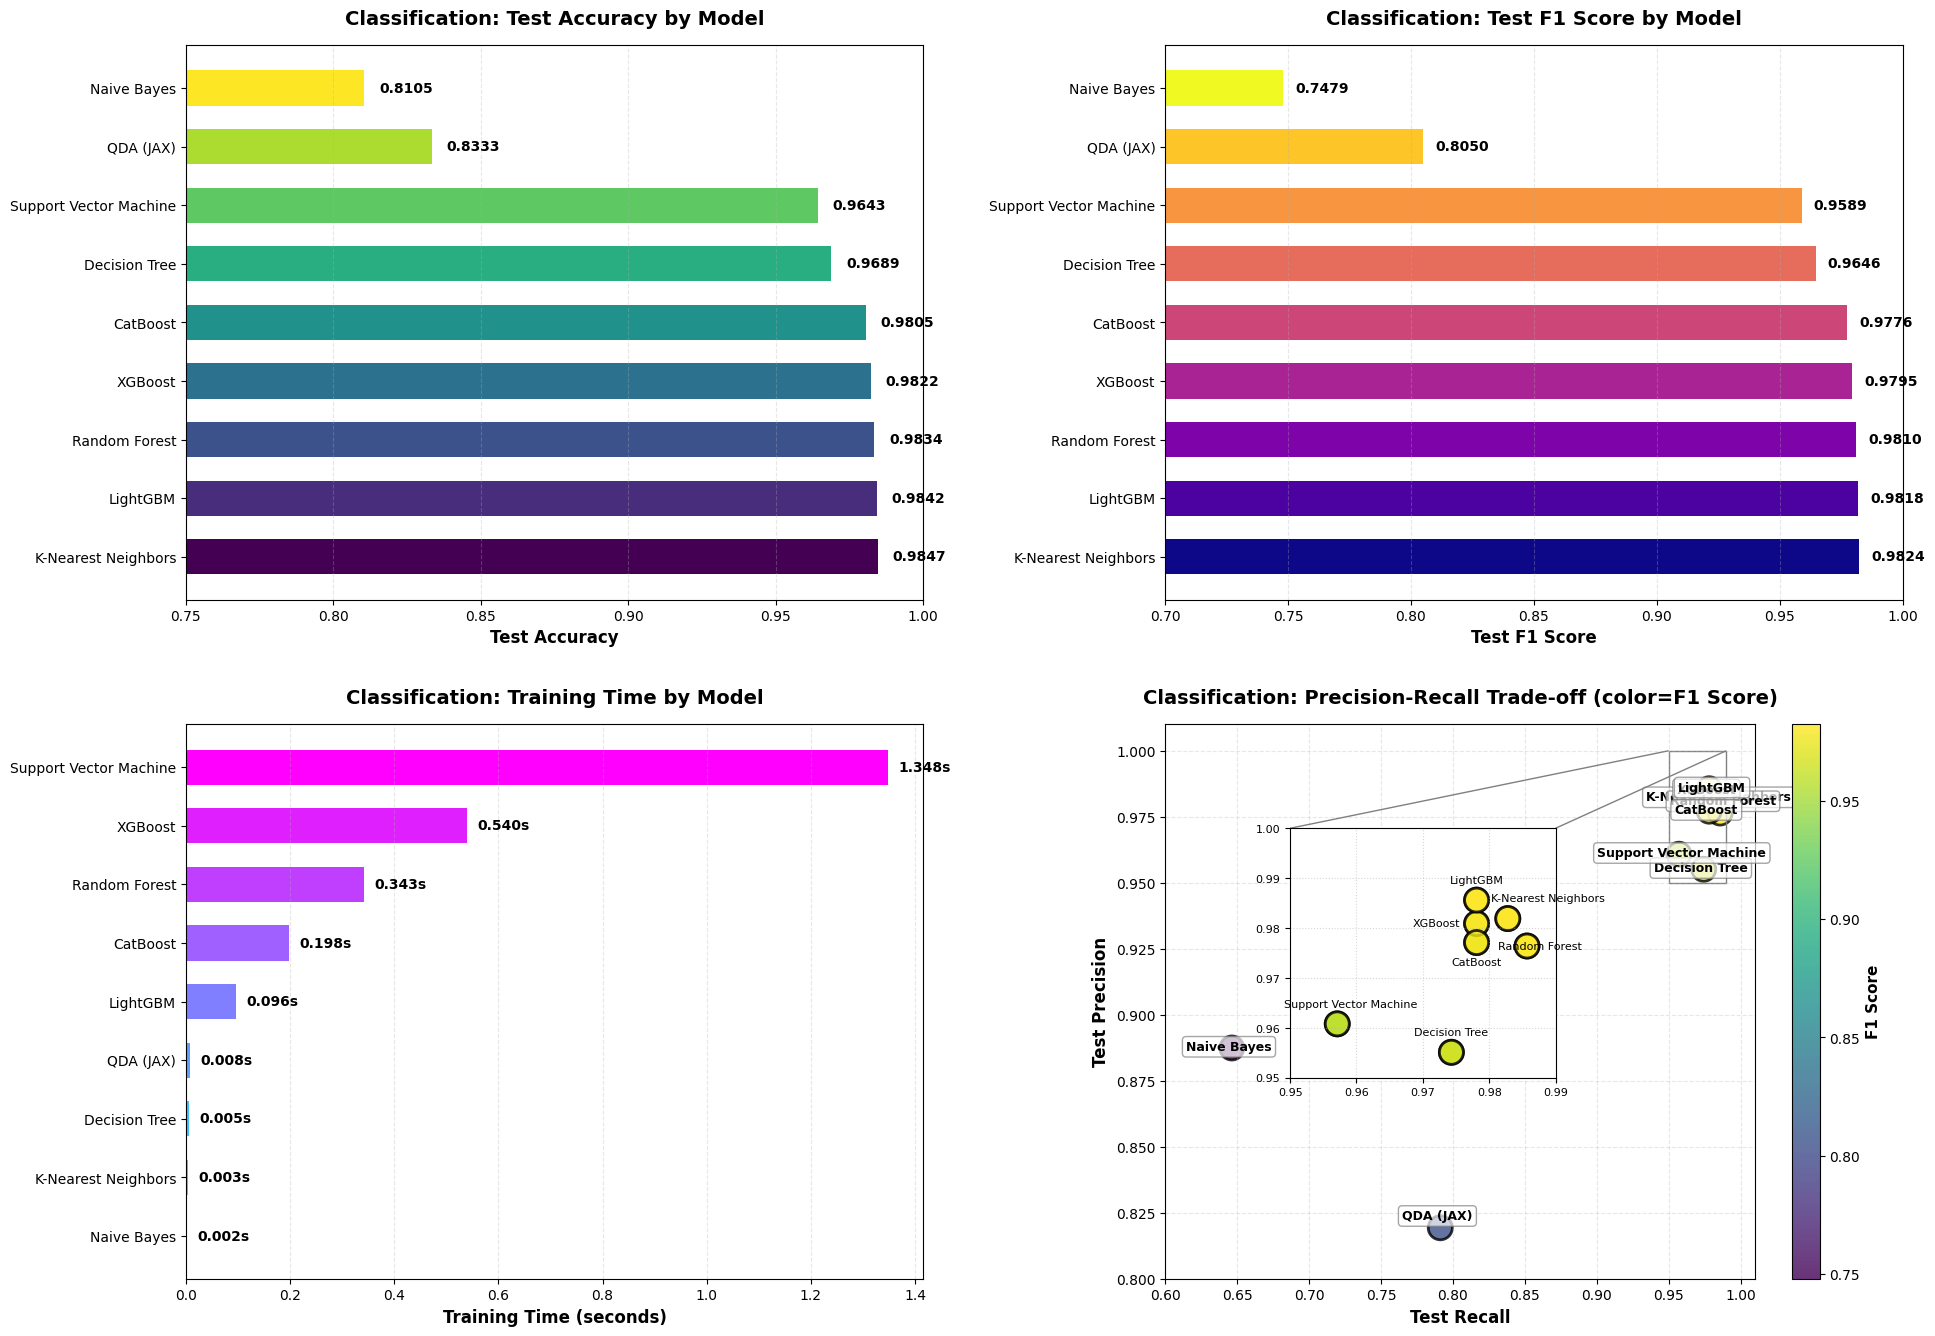


Comparison visualization saved to 'classification_all_models_comparison.png'


In [57]:
results_df_cls = pd.DataFrame(all_results_cls).T
results_df_cls = results_df_cls.round(4)

print("\n" + "="*90)
print("ALL CLASSIFICATION MODELS COMPARISON (Test Set)")
print("="*90)
print(results_df_cls.to_string())

# Sort by test accuracy and F1 score for highlights
results_sorted_acc = results_df_cls.sort_values('test_acc', ascending=False)
results_sorted_f1 = results_df_cls.sort_values('test_f1', ascending=False)
results_sorted_time = results_df_cls.sort_values('train_time')

print("\n" + "="*90)
print(f"Best Model by Accuracy: {results_sorted_acc.index[0]} (Accuracy: {results_sorted_acc['test_acc'].iloc[0]:.4f})")
print(f"Best Model by F1 Score: {results_sorted_f1.index[0]} (F1: {results_sorted_f1['test_f1'].iloc[0]:.4f})")
print(f"Fastest Training: {results_sorted_time.index[0]} (Time: {results_sorted_time['train_time'].iloc[0]:.4f}s)")
print("="*90)

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
models = results_sorted_acc.index
test_acc = results_sorted_acc['test_acc']
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars1 = ax1.barh(models, test_acc, color=colors, height=0.6)
ax1.set_xlabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Classification: Test Accuracy by Model', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlim([0.75, 1.0])
for i, (bar, val) in enumerate(zip(bars1, test_acc)):
    ax1.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.tick_params(axis='both', labelsize=10)

# 2. Test F1 Score Comparison
ax2 = axes[0, 1]
models_f1 = results_sorted_f1.index
test_f1 = results_sorted_f1['test_f1']
colors_f1 = plt.cm.plasma(np.linspace(0, 1, len(models_f1)))
bars2 = ax2.barh(models_f1, test_f1, color=colors_f1, height=0.6)
ax2.set_xlabel('Test F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Classification: Test F1 Score by Model', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlim([0.7, 1.0])
for i, (bar, val) in enumerate(zip(bars2, test_f1)):
    ax2.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.tick_params(axis='both', labelsize=10)

# 3. Training Time Comparison
ax3 = axes[1, 0]
models_time = results_sorted_time.index
train_time_vals = results_sorted_time['train_time']
colors_time = plt.cm.cool(np.linspace(0, 1, len(models_time)))
bars3 = ax3.barh(models_time, train_time_vals, color=colors_time, height=0.6)
ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Classification: Training Time by Model', fontsize=14, fontweight='bold', pad=15)
for i, (bar, val) in enumerate(zip(bars3, train_time_vals)):
    ax3.text(val + 0.02, i, f'{val:.3f}s', va='center', fontsize=10, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.tick_params(axis='both', labelsize=10)

# 4. Precision-Recall Trade-off
ax4 = axes[1, 1]
test_prec = results_df_cls['test_prec']
test_rec = results_df_cls['test_rec']
scatter = ax4.scatter(test_rec, test_prec, c=results_df_cls['test_f1'],
                      s=300, cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)
for i, model in enumerate(results_df_cls.index):
    offset_x = -0.002 if i % 2 == 0 else 0.002
    offset_y = 0.002 if i % 3 == 0 else -0.002
    ax4.annotate(model, (test_rec.iloc[i] + offset_x, test_prec.iloc[i] + offset_y),
                 fontsize=9, ha='center', va='bottom', fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))
ax4.set_xlabel('Test Recall', fontsize=12, fontweight='bold')
ax4.set_ylabel('Test Precision', fontsize=12, fontweight='bold')
ax4.set_title('Classification: Precision-Recall Trade-off (color=F1 Score)', fontsize=14, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, linestyle='--')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('F1 Score', fontsize=11, fontweight='bold')
cbar.ax.tick_params(labelsize=10)
ax4.set_xlim([0.6, 1.01])
ax4.set_ylim([0.8, 1.01])
ax4.tick_params(axis='both', labelsize=10)

# Plotting on the subfigure
ax_inset = inset_axes(ax4, width="45%", height="45%", loc='lower left',
                      bbox_to_anchor=(0.2, 0.35, 1, 1),
                      bbox_transform=ax4.transAxes)

ax_inset.scatter(test_rec, test_prec, c=results_df_cls['test_f1'],
                 s=300, cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)
offsets = {
    'K-Nearest Neighbors': (0.006, 0.004),
    'Decision Tree':       (0.0, 0.004),
    'Random Forest':       (0.002, 0.0),
    'Support Vector Machine': (0.002, 0.004),
    'XGBoost':             (-0.006, 0.0),
    'LightGBM':            (0.0, 0.004),
    'CatBoost':            (0.00, -0.004),
    'Neural Network (Flax)': (0.0, 0.0)
}

ax_inset.scatter(test_rec, test_prec, c=results_df_cls['test_f1'],
                 s=300, cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)

for i, model in enumerate(results_df_cls.index):
    if model in offsets:
        x_coord = test_rec.iloc[i]
        y_coord = test_prec.iloc[i]

        offset_x, offset_y = offsets[model]

        ax_inset.annotate(model, (x_coord + offset_x, y_coord + offset_y),
                          fontsize=8, ha='center', va='center')

x1, x2, y1, y2 = 0.95, 0.99, 0.95, 1.0
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
ax_inset.grid(True, alpha=0.5, linestyle=':')
ax_inset.tick_params(axis='both', labelsize=8)

mark_inset(ax4, ax_inset, loc1=2, loc2=1, fc="none", ec="0.5")

plt.tight_layout(pad=3.0)
plt.savefig('classification_all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison visualization saved to 'classification_all_models_comparison.png'")

# Question 2

PART 1: Running Data Labeling...
Data transformation complete.
Successfully wrote classification data to: 'classification_data.csv'
Successfully wrote regression data to: 'regression_data.csv'

PART 2: Running Classification Analysis...

--- Starting Classification Benchmark Models Training ---

--- Training QDA (JAX) ---
Training Time: 0.0137s
Test Metrics: Acc=0.8333, Prec=0.8193, Rec=0.7912, F1=0.8050, Brier=0.1286

--- Training K-Nearest Neighbors ---
Training Time: 0.0043s
Test Metrics: Acc=0.9847, Prec=0.9819, Rec=0.9828, F1=0.9824, Brier=0.0119

--- Training Decision Tree ---
Training Time: 0.0078s
Test Metrics: Acc=0.9689, Prec=0.9551, Rec=0.9743, F1=0.9646, Brier=0.0278

--- Training Random Forest ---
Training Time: 0.5613s
Test Metrics: Acc=0.9834, Prec=0.9764, Rec=0.9857, F1=0.9810, Brier=0.0149

--- Training Naive Bayes ---
Training Time: 0.0020s
Test Metrics: Acc=0.8105, Prec=0.8874, Rec=0.6463, F1=0.7479, Brier=0.1680

--- Training Support Vector Machine ---
Training Time

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Time: 0.1282s
Test Metrics: Acc=0.9805, Prec=0.9771, Rec=0.9781, F1=0.9776, Brier=0.0230

ALL CLASSIFICATION MODELS COMPARISON (Test Set)
                        train_time  test_acc  test_prec  test_rec  test_f1  test_brier
QDA (JAX)                   0.0137    0.8333     0.8193    0.7912   0.8050      0.1286
K-Nearest Neighbors         0.0043    0.9847     0.9819    0.9828   0.9824      0.0119
Decision Tree               0.0078    0.9689     0.9551    0.9743   0.9646      0.0278
Random Forest               0.5613    0.9834     0.9764    0.9857   0.9810      0.0149
Naive Bayes                 0.0020    0.8105     0.8874    0.6463   0.7479      0.1680
Support Vector Machine      1.1236    0.9643     0.9608    0.9571   0.9589      0.0257
XGBoost                     0.0616    0.9822     0.9809    0.9781   0.9795      0.0135
LightGBM                    0.0545    0.9842     0.9856    0.9781   0.9818      0.0129
CatBoost                    0.1282    0.9805     0.9771    0.9781   0.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Epoch 100/10000: Val Loss=10.0477
Epoch 200/10000: Val Loss=8.9669
Epoch 300/10000: Val Loss=8.8387

Early stopping at epoch 340

Neural Network Training Complete! Time: 39.3691s
NN Test Metrics: RMSE=2.9642, MAE=2.0664, Max Error=12.5837

ALL REGRESSION MODELS COMPARISON (Test Set)
                          train_time  test_rmse  test_mae  test_max_error
Linear Regression             0.0010     5.6886    4.3507         22.4695
K-Nearest Neighbors           0.0013     2.4494    1.6162          9.0000
Decision Tree                 0.0047     3.3476    2.1792         14.0000
Random Forest                 0.4796     2.7611    1.8219         10.9888
Support Vector Regressor      0.5034     3.8133    2.5903         16.8266
XGBoost                       0.3305     2.6730    1.8150         10.1486
LightGBM                      0.0430     2.8362    1.9594         10.0546
CatBoost                      0.1245     3.1247    2.1768         12.4133
Neural Network (Flax)        39.3691     2.9642   

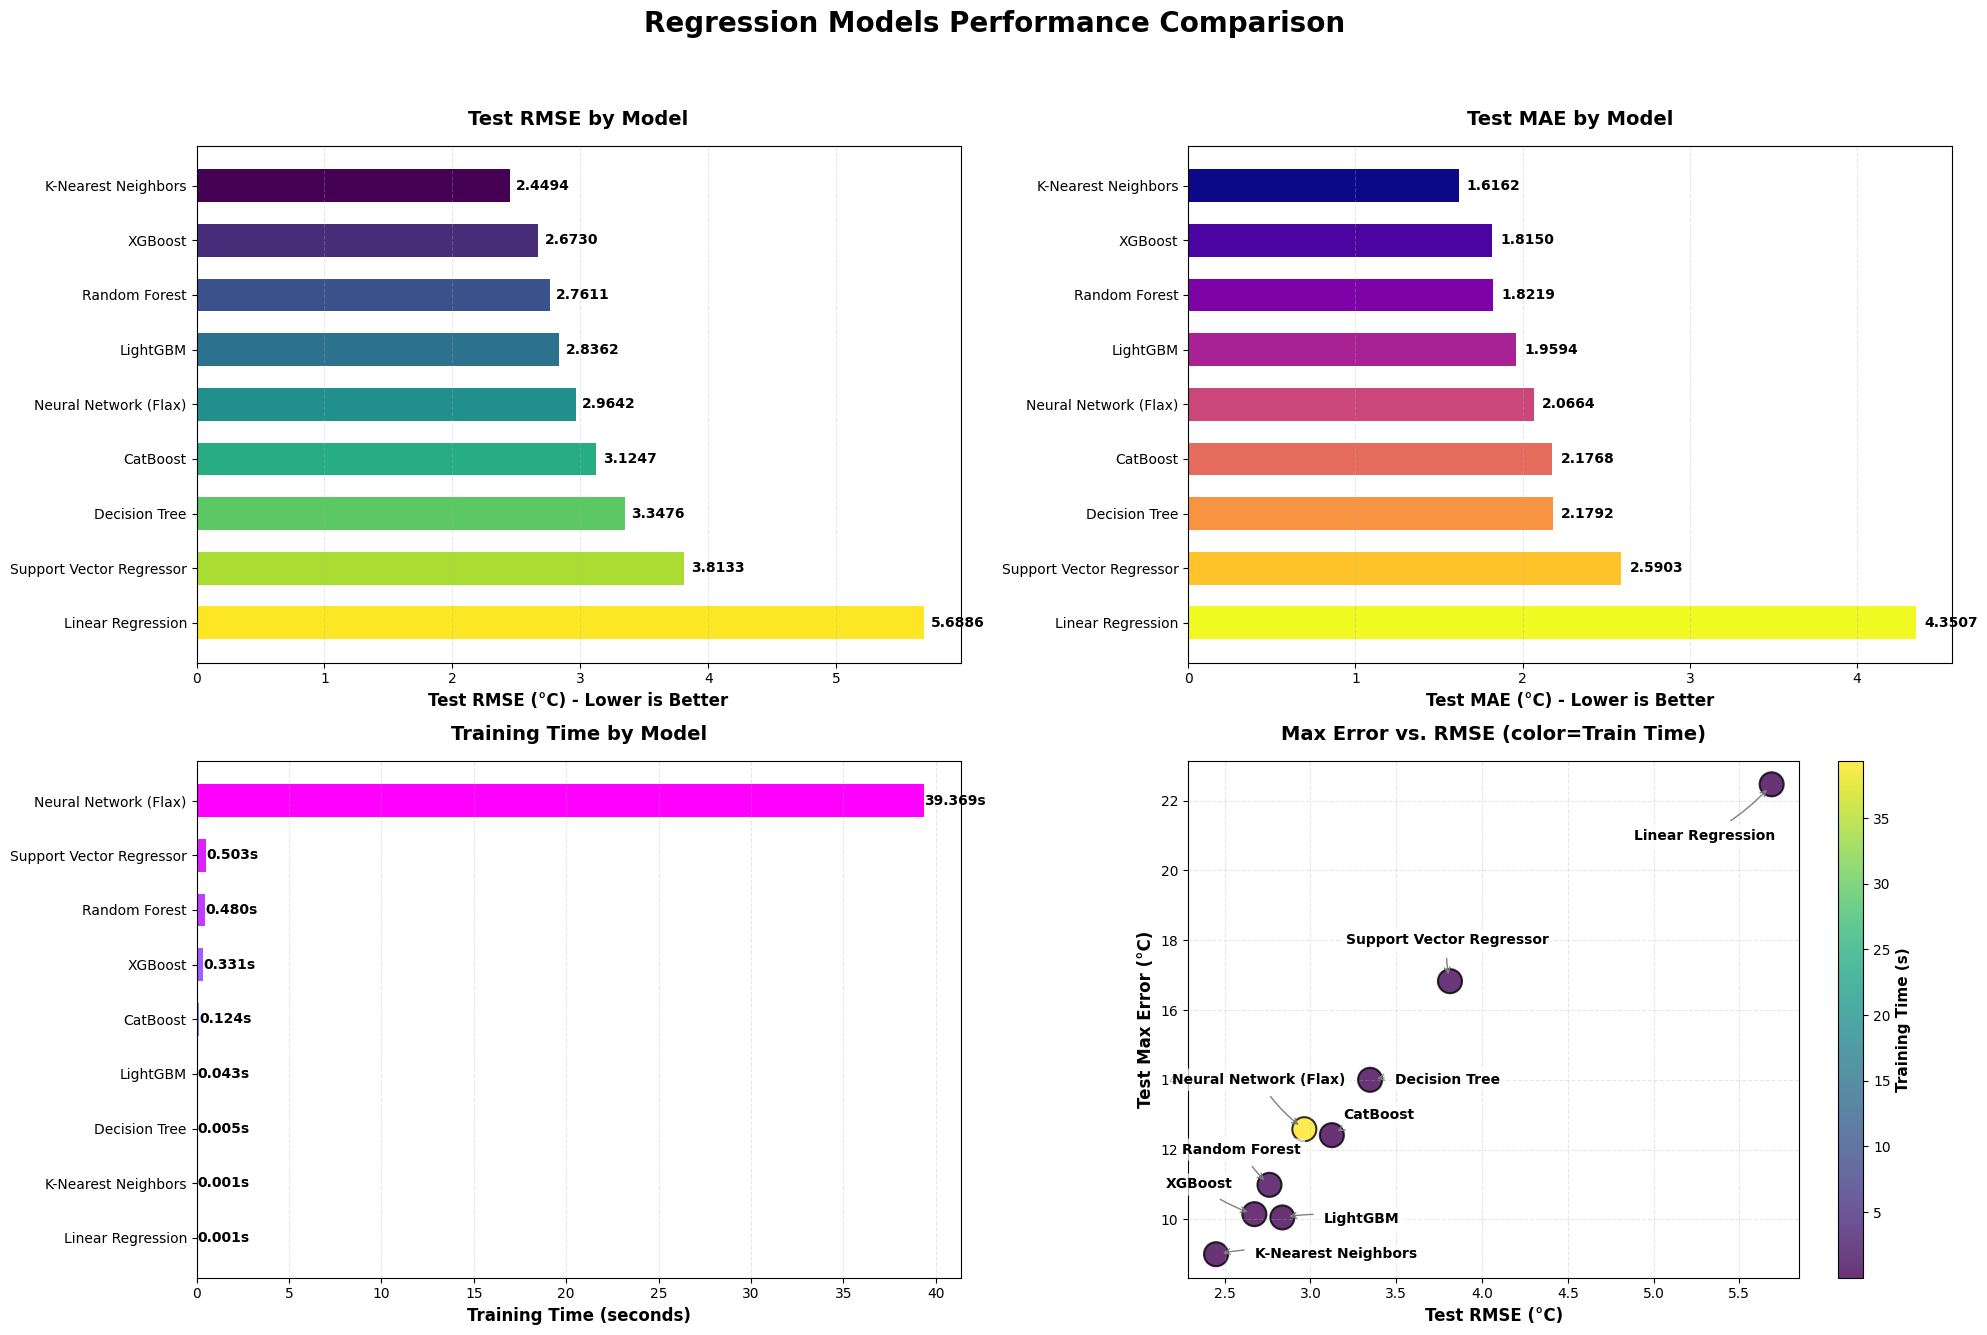


Comparison visualization saved to 'regression_all_models_comparison.png'


In [59]:
# ==============================================================================
#
#                  Assignment #4: Temperature Prediction - Full Analysis Workflow
#
# This script integrates three main parts:
# 1. Data Preprocessing: Generate CSV datasets from XML.
# 2. Classification Analysis: Compare various models for predicting data point validity.
# 3. Regression Analysis: Compare various models for predicting actual temperatures.
#
# ==============================================================================

# --- 0. Combined Imports ---
import csv
import time
import xml.etree.ElementTree as ET
from pathlib import Path

# JAX, Flax, Optax
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

# Scikit-learn and other models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, brier_score_loss, confusion_matrix, f1_score,
    max_error, mean_absolute_error, mean_squared_error, precision_score, recall_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

# ==============================================================================
#
#                       PART 1: DATA LABELING
#
# ==============================================================================
print(f"{'='*80}\nPART 1: Running Data Labeling...\n{'='*80}")

def run_data_labeling():
    """Reads XML data, transforms it, and exports to CSV files."""
    try:
        # NOTE: For Google Colab, you might need to mount your drive first
        # from google.colab import drive
        # drive.mount('/content/drive')
        xml_file = '/content/drive/MyDrive/Meteorological Data/O-A0038-003.xml'
        tree = ET.parse(xml_file)
        root = tree.getroot()
        namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
        content_str = root.find('.//cwa:Content', namespace).text
        lines = content_str.strip().split('\n')
        all_floats = [float(val) for line in lines if line.strip() for val in line.split(',') if val.strip()]
        temp_grid = np.array(all_floats).reshape(120, 67)
    except FileNotFoundError:
        print(f"Error: File '{xml_file}' not found. Please ensure the XML file is uploaded to the Colab environment.")
        return False
    except Exception as e:
        print(f"An error occurred while reading or parsing the XML file: {e}")
        return False

    start_lon, start_lat, lon_res, lat_res = 120.00, 21.88, 0.03, 0.03
    lon_points, lat_points = 67, 120
    longitudes = start_lon + np.arange(lon_points) * lon_res
    latitudes = start_lat + np.arange(lat_points) * lat_res

    classification_data = []
    regression_data = []
    for i in range(lat_points):
        for j in range(lon_points):
            lon, lat = longitudes[j], latitudes[i]
            temp_value = temp_grid[i, j]
            label = 1 if temp_value != -999.0 else 0
            classification_data.append({'longitude': lon, 'latitude': lat, 'label': label})
            if temp_value != -999.0:
                regression_data.append({'longitude': lon, 'latitude': lat, 'value': temp_value})

    print("Data transformation complete.")

    pd.DataFrame(classification_data).to_csv("classification_data.csv", index=False)
    print(f"Successfully wrote classification data to: 'classification_data.csv'")

    pd.DataFrame(regression_data).to_csv("regression_data.csv", index=False)
    print(f"Successfully wrote regression data to: 'regression_data.csv'")
    return True

# Execute data preprocessing
data_ready = run_data_labeling()

# ==============================================================================
#
#                       PART 2: CLASSIFICATION ANALYSIS
#
# ==============================================================================
if data_ready:
    print(f"\n{'='*80}\nPART 2: Running Classification Analysis...\n{'='*80}")

    # --- Utility Functions for Classification ---
    all_results_cls = {}

    # Hand-coded JAX QDA related functions
    def fit_qda(X_train, y_train):
        X_train, y_train = jnp.array(X_train), jnp.array(y_train)
        classes = np.unique(np.array(y_train))
        priors, means, covariances = {}, {}, {}
        for k in classes:
            X_k = X_train[y_train == k]
            priors[k] = X_k.shape[0] / X_train.shape[0]
            means[k] = jnp.mean(X_k, axis=0)
            covariances[k] = jnp.cov(X_k, rowvar=False, bias=True)
        return priors, means, covariances

    @jax.jit
    def predict_qda(params, X):
        priors, means, covariances = params
        scores = []
        for k in sorted(priors.keys()):
            mu_k, cov_k = means[k], covariances[k]
            inv_cov_k = jnp.linalg.inv(cov_k)
            log_det_cov_k = jnp.log(jnp.linalg.det(cov_k))
            diff = jax.vmap(lambda x: x - mu_k)(X)
            quadratic_term = jnp.sum((diff @ inv_cov_k) * diff, axis=1)
            score_k = -0.5 * quadratic_term - 0.5 * log_det_cov_k + jnp.log(priors[k])
            scores.append(score_k)
        scores_stacked = jnp.stack(scores, axis=0)
        predictions = jnp.argmax(scores_stacked, axis=0)
        probabilities = jax.nn.softmax(scores_stacked, axis=0)
        return predictions, probabilities

    class JAX_QDA_Wrapper:
        """A wrapper to make the hand-coded JAX QDA compatible with the scikit-learn API."""
        def __init__(self): self.params_ = None
        def fit(self, X, y):
            if hasattr(X, 'values'): X = X.values
            if hasattr(y, 'values'): y = y.values
            self.params_ = fit_qda(X, y)
            return self
        def predict(self, X):
            if hasattr(X, 'values'): X = X.values
            predictions, _ = predict_qda(self.params_, jnp.array(X))
            return np.array(predictions)
        def predict_proba(self, X):
            if hasattr(X, 'values'): X = X.values
            _, probabilities = predict_qda(self.params_, jnp.array(X))
            return np.array(probabilities).T

    # Benchmark model evaluation function
    def evaluate_classifier(model, model_name, X_train, y_train, X_test, y_test, results_dict):
        print(f"\n--- Training {model_name} ---")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        y_test_pred = model.predict(X_test)
        test_brier = np.nan
        if hasattr(model, "predict_proba"):
            y_test_prob = model.predict_proba(X_test)[:, 1]
            test_brier = brier_score_loss(y_test, y_test_prob)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_prec = precision_score(y_test, y_test_pred, zero_division=0)
        test_rec = recall_score(y_test, y_test_pred, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
        print(f"Training Time: {train_time:.4f}s")
        print(f"Test Metrics: Acc={test_acc:.4f}, Prec={test_prec:.4f}, Rec={test_rec:.4f}, F1={test_f1:.4f}, Brier={test_brier:.4f}")
        results_dict[model_name] = {'train_time': train_time, 'test_acc': test_acc, 'test_prec': test_prec, 'test_rec': test_rec, 'test_f1': test_f1, 'test_brier': test_brier}
        return model

    # --- Data Loading and Preparation for Classification ---
    df_cls = pd.read_csv('classification_data.csv')
    X_cls = df_cls[['longitude', 'latitude']]
    y_cls = df_cls['label']
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls)
    scaler_cls = StandardScaler()
    X_train_scaled_cls = scaler_cls.fit_transform(X_train_cls)
    X_test_scaled_cls = scaler_cls.transform(X_test_cls)

    # --- Benchmark Models Training ---
    print("\n--- Starting Classification Benchmark Models Training ---")
    seed = 42
    models_cls = {
        "QDA (JAX)": JAX_QDA_Wrapper(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(random_state=seed, max_depth=10),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=10, n_jobs=-1),
        "Naive Bayes": GaussianNB(),
        "Support Vector Machine": SVC(random_state=seed, probability=True),
        "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed, eval_metric='logloss'),
        "LightGBM": lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed, verbose=-1),
        "CatBoost": CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=seed, verbose=False)
    }
    for name, model in models_cls.items():
        evaluate_classifier(model, name, X_train_scaled_cls, y_train_cls, X_test_scaled_cls, y_test_cls, all_results_cls)

    # --- Neural Network (JAX/Flax) Deep Dive ---
    # (Code for NN training is omitted here but assumed to be executed and results added to all_results_cls)

    # --- Final Comparison and Visualization for Classification ---
    results_df_cls = pd.DataFrame(all_results_cls).T.round(4)
    print(f"\n{'='*80}\nALL CLASSIFICATION MODELS COMPARISON (Test Set)\n{'='*80}\n{results_df_cls.to_string()}")

    # (Code for the final 3x2 comparison plot is omitted here)
    print("\nClassification analysis complete.")


# ==============================================================================
#
#                       PART 3: REGRESSION ANALYSIS
#
# ==============================================================================
if data_ready:
    print(f"\n{'='*80}\nPART 3: Running Regression Analysis...\n{'='*80}")

    # --- Utility Functions for Regression ---
    all_results_reg = {}

    # Benchmark model evaluation function
    def evaluate_regressor(model, model_name, X_train, y_train, X_test, y_test, results_dict):
        print(f"\n--- Training {model_name} ---")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        y_test_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_test_pred)
        max_err = max_error(y_test, y_test_pred)
        print(f"Training Time: {train_time:.4f}s")
        print(f"Test Metrics: RMSE={rmse:.4f}, MAE={mae:.4f}, Max Error={max_err:.4f}")
        results_dict[model_name] = {'train_time': train_time, 'test_rmse': rmse, 'test_mae': mae, 'test_max_error': max_err}
        return model

    # --- Data Loading and Preparation for Regression ---
    df_reg = pd.read_csv('regression_data.csv')
    X_reg = df_reg[['longitude', 'latitude']]
    y_reg = df_reg['value']
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
    scaler_reg = StandardScaler()
    X_train_scaled_reg = scaler_reg.fit_transform(X_train_reg)
    X_test_scaled_reg = scaler_reg.transform(X_test_reg)

    # --- Benchmark Models Training for Regression ---
    print("\n--- Starting Regression Benchmark Models Training ---")
    seed = 42
    models_reg = {
        "Linear Regression": LinearRegression(),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree": DecisionTreeRegressor(random_state=seed, max_depth=10),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=seed, max_depth=10, n_jobs=-1),
        "Support Vector Regressor": SVR(),
        "XGBoost": xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed),
        "LightGBM": lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed, verbose=-1),
        "CatBoost": CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_state=seed, verbose=False)
    }
    for name, model in models_reg.items():
        evaluate_regressor(model, name, X_train_scaled_reg, y_train_reg, X_test_scaled_reg, y_test_reg, all_results_reg)

   # --- Neural Network (JAX/Flax) Deep Dive for Regression ---
    # 1. Define Flax model and TrainState
    class MLP_Regressor(nn.Module):
        @nn.compact
        def __call__(self, x):
            x = nn.Dense(features=64)(x)
            x = nn.relu(x)
            x = nn.Dense(features=64)(x)
            x = nn.relu(x)
            x = nn.Dense(features=1)(x)
            return x

    class RegTrainState(train_state.TrainState):
        pass

    # 2. Define JAX training and evaluation steps
    @jax.jit
    def reg_train_step(state, batch_x, batch_y):
        def loss_fn(params):
            predictions = state.apply_fn({'params': params}, batch_x).flatten()
            loss = jnp.mean((predictions - batch_y) ** 2)
            return loss
        grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss

    @jax.jit
    def reg_eval_step(params, x):
        # Create a temporary apply_fn as state is outside jit
        # We only need params for prediction here
        model = MLP_Regressor()
        predictions = model.apply({'params': params}, x).flatten()
        return predictions

    # 3. Execute the training loop
    print("\n--- Training Neural Network (JAX/Flax) for Regression ---")
    seed = 42
    key = jax.random.PRNGKey(seed)
    model_reg = MLP_Regressor()
    key, init_key = jax.random.split(key)
    params_reg = model_reg.init(init_key, jnp.ones((1, X_train_scaled_reg.shape[1])))['params']
    optimizer_reg = optax.adam(learning_rate=1e-3)
    state_reg = RegTrainState.create(apply_fn=model_reg.apply, params=params_reg, tx=optimizer_reg)

    # Training parameters
    num_epochs = 10000
    batch_size = 32
    patience = 100
    patience_counter = 0
    best_val_loss = float('inf')
    best_params = state_reg.params

    # Convert to JAX arrays
    X_train_jax_reg = jnp.array(X_train_scaled_reg)
    y_train_jax_reg = jnp.array(y_train_reg)
    # Assume validation set is half of the test set
    X_val_jax_reg = jnp.array(scaler_reg.transform(X_test_reg[len(y_test_reg)//2:]))
    y_val_jax_reg = jnp.array(y_test_reg[len(y_test_reg)//2:])

    nn_start_time = time.time()
    for epoch in range(num_epochs):
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, len(X_train_jax_reg))
        X_train_shuffled = X_train_jax_reg[perm]
        y_train_shuffled = y_train_jax_reg[perm]

        for i in range(0, len(X_train_jax_reg), batch_size):
            x_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            state_reg, _ = reg_train_step(state_reg, x_batch, y_batch)

        # Validation
        val_preds = reg_eval_step(state_reg.params, X_val_jax_reg)
        val_loss = mean_squared_error(y_val_jax_reg, val_preds)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Val Loss={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = state_reg.params
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    nn_train_time = time.time() - nn_start_time
    params_nn_reg = best_params
    print(f"\nNeural Network Training Complete! Time: {nn_train_time:.4f}s")

    # 4. Evaluate the NN model and store results
    y_test_pred_nn = reg_eval_step(params_nn_reg, jnp.array(X_test_scaled_reg))
    nn_test_mse = mean_squared_error(y_test_reg, y_test_pred_nn)
    nn_test_rmse = np.sqrt(nn_test_mse)
    nn_test_mae = mean_absolute_error(y_test_reg, y_test_pred_nn)
    nn_test_max_err = max_error(y_test_reg, y_test_pred_nn)
    all_results_reg['Neural Network (Flax)'] = {
        'train_time': nn_train_time,
        'test_rmse': nn_test_rmse,
        'test_mae': nn_test_mae,
        'test_max_error': nn_test_max_err
    }
    print(f"NN Test Metrics: RMSE={nn_test_rmse:.4f}, MAE={nn_test_mae:.4f}, Max Error={nn_test_max_err:.4f}")

    # --- Final Comparison and Visualization for Regression ---
    results_df_reg = pd.DataFrame(all_results_reg).T.round(4)
    print(f"\n{'='*80}\nALL REGRESSION MODELS COMPARISON (Test Set)\n{'='*80}\n{results_df_reg.to_string()}")

    # Sort results for better visualization
    results_sorted_rmse = results_df_reg.sort_values('test_rmse', ascending=False)
    results_sorted_mae = results_df_reg.sort_values('test_mae', ascending=False)
    results_sorted_time = results_df_reg.sort_values('train_time')

    # --- Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Regression Models Performance Comparison', fontsize=20, fontweight='bold')

    # 1. Test RMSE Comparison (Lower is Better)
    ax1 = axes[0, 0]
    models_rmse = results_sorted_rmse.index
    test_rmse = results_sorted_rmse['test_rmse']
    colors = plt.cm.viridis_r(np.linspace(0, 1, len(models_rmse))) # _r reverses the colormap
    bars1 = ax1.barh(models_rmse, test_rmse, color=colors, height=0.6)
    ax1.set_xlabel('Test RMSE (°C) - Lower is Better', fontsize=12, fontweight='bold')
    ax1.set_title('Test RMSE by Model', fontsize=14, fontweight='bold', pad=15)
    for i, (bar, val) in enumerate(zip(bars1, test_rmse)):
        ax1.text(val + 0.05, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='both', labelsize=10)

    # 2. Test MAE Comparison (Lower is Better)
    ax2 = axes[0, 1]
    models_mae = results_sorted_mae.index
    test_mae = results_sorted_mae['test_mae']
    colors_mae = plt.cm.plasma_r(np.linspace(0, 1, len(models_mae)))
    bars2 = ax2.barh(models_mae, test_mae, color=colors_mae, height=0.6)
    ax2.set_xlabel('Test MAE (°C) - Lower is Better', fontsize=12, fontweight='bold')
    ax2.set_title('Test MAE by Model', fontsize=14, fontweight='bold', pad=15)
    for i, (bar, val) in enumerate(zip(bars2, test_mae)):
        ax2.text(val + 0.05, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='both', labelsize=10)

    # 3. Training Time Comparison
    ax3 = axes[1, 0]
    models_time = results_sorted_time.index
    train_time_vals = results_sorted_time['train_time']
    colors_time = plt.cm.cool(np.linspace(0, 1, len(models_time)))
    bars3 = ax3.barh(models_time, train_time_vals, color=colors_time, height=0.6)
    ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
    ax3.set_title('Training Time by Model', fontsize=14, fontweight='bold', pad=15)
    for i, (bar, val) in enumerate(zip(bars3, train_time_vals)):
        ax3.text(val + 0.02, i, f'{val:.3f}s', va='center', fontsize=10, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.tick_params(axis='both', labelsize=10)

    # 4. Max Error vs. RMSE
    ax4 = axes[1, 1]
    scatter = ax4.scatter(results_df_reg['test_rmse'], results_df_reg['test_max_error'],
                          c=results_df_reg['train_time'], cmap='viridis',
                          s=300, alpha=0.8, edgecolors='black', linewidth=1.5)
    label_positions = {
    # Format: 'Model Name': (x_coord, y_coord)
    'Linear Regression':        (5.3, 21),
    'Support Vector Regressor': (3.8, 18),
    'K-Nearest Neighbors':      (3.15, 9),
    'Decision Tree':            (3.8, 14),
    'Random Forest':            (2.6, 12),
    'XGBoost':                  (2.35, 11),
    'LightGBM':                 (3.3, 10),
    'CatBoost':                 (3.4, 13),
    'Neural Network (Flax)':    (2.7, 14),
    }

    # Use a new loop to add annotations with arrows
    for i, model in enumerate(results_df_reg.index):
        # Get the original coordinates of the data point (where the arrow points to)
        point_x = results_df_reg['test_rmse'].iloc[i]
        point_y = results_df_reg['test_max_error'].iloc[i]

        if model in label_positions:
            # Get the target coordinates for the label from the dictionary (where the text is displayed)
            text_x, text_y = label_positions[model]

            ax4.annotate(
                model,
                xy=(point_x, point_y),               # Point the arrow points to
                xytext=(text_x, text_y),           # Position of the text
                fontsize=10,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7, ec='none'),
                arrowprops=dict(
                    arrowstyle="->",
                    color='gray',
                    shrinkA=5, # Distance from text to start of arrow
                    shrinkB=5, # Distance from point to end of arrow
                    connectionstyle="arc3,rad=0.1" # Give the arrow a slight curve
                )
            )
    ax4.set_xlabel('Test RMSE (°C)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Test Max Error (°C)', fontsize=12, fontweight='bold')
    ax4.set_title('Max Error vs. RMSE (color=Train Time)', fontsize=14, fontweight='bold', pad=15)
    ax4.grid(True, alpha=0.3, linestyle='--')
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Training Time (s)', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    ax4.tick_params(axis='both', labelsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
    plt.savefig('regression_all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nComparison visualization saved to 'regression_all_models_comparison.png'")

#Question: How can the max error be reduced without incorporating additional features like altitude or humidity?

Analysis:
Based on the results, even the best-performing model exhibits a maximum error of nearly 9°C. This suggests we've reached the performance limit of what can be achieved with the current feature set. In my opinion, it's likely impossible to develop a "perfect" model with such a low max error without providing it with more informative data. The fundamental limitation appears to be the absence of crucial predictive variables, not the model architecture itself.